# Model validation stations

Note: this notebook requires the model output data

<div class="alert alert-warning" role="alert">
  <strong>⚠️ Important Disclaimer</strong><br><br>
  This model setup is a <strong>simplified version</strong> of a detailed model developed by DHI. It does <strong>not</strong> resolve fine-scale processes and is <strong>not calibrated</strong> for operational use. Use is limited to <strong>educational and research purposes only</strong> — results should <strong>not</strong> inform decision-making. Performance shown here does <strong>not</strong> represent that of DHI’s high-resolution models.
</div>

### Import packages

In [24]:
import modelskill as ms
import matplotlib.pyplot as plt
import helper as h
import plotting as pl
import pandas as pd
from pathlib import Path

In [27]:
import importlib
importlib.reload(h)

<module 'helper' from 'c:\\Users\\muje\\Projects\\WaterBench-MIKE21SW-SouthernNorthSea\\code\\helper.py'>

### Define paths

In [43]:
obs_fldr = "../observations/" 
#mr_fldr = "../output/"    
mr_fldr = "../output_sample/"     # use this if you have not downloaded the full data from Zenodo yet
mr_fn = f"{mr_fldr}Area.dfsu"

In [44]:
# Load observation data
swhlist = h.get_swh_point_obs(station_file="stations_subset.csv")
tplist = h.get_tp_point_obs(station_file="stations_subset.csv")
mwdlist = h.get_mwd_point_obs(station_file="stations.csv")


In [45]:
# Load MIKE21 simulation data
mr_swh = ms.DfsuModelResult(mr_fn, name="MIKE21", item=0)
mr_tp = ms.DfsuModelResult(mr_fn, name="MIKE21", item=1)
mr_dir = ms.DfsuModelResult(mr_fn, name="MIKE21", item=3)
mr_dir

<DfsuModelResult>: MIKE21
Time: 2022-01-03 00:00:00 - 2022-01-09 23:30:00
Quantity: Mean Wave Direction [degree]

### Create modelskill comparer collection

We consider both significant wave height (swh), peak wave period (tp) and mean wave direction (mwd).

In [46]:
# swh 
cmps = []
for o in swhlist:
    try:
        cmps.append(ms.match(obs=o, mod=mr_swh))
    except Exception as e:
        print(f"Skipping {o.name} due to error: {e}")

cc_swh = ms.ComparerCollection(cmps)

Skipping Oosterschelde11 due to error: No data left after trimming to 2022-01-02 23:59:59 - 2022-01-09 23:30:01
Skipping Q1_ due to error: No data left after trimming to 2022-01-02 23:59:59 - 2022-01-09 23:30:01


c:\Users\muje\Projects\WaterBench-MIKE21SW-SouthernNorthSea\.venv\Lib\site-packages\modelskill\model\_base.py:70: UserWarning: No time overlap. Observation 'Oosterschelde11' outside model time range! 
  warnings.warn(
c:\Users\muje\Projects\WaterBench-MIKE21SW-SouthernNorthSea\.venv\Lib\site-packages\modelskill\model\_base.py:70: UserWarning: No time overlap. Observation 'Q1_' outside model time range! 
  warnings.warn(


In [47]:
# tp
cmps = []
for o in tplist:
    try:
        cmps.append(ms.match(obs=o, mod=mr_tp))
    except Exception as e:
        print(f"Skipping {o.name} due to error: {e}")
        
cc_tp = ms.ComparerCollection(cmps)

c:\Users\muje\Projects\WaterBench-MIKE21SW-SouthernNorthSea\.venv\Lib\site-packages\modelskill\model\_base.py:70: UserWarning: No time overlap. Observation 'Oosterschelde11' outside model time range! 
  warnings.warn(
c:\Users\muje\Projects\WaterBench-MIKE21SW-SouthernNorthSea\.venv\Lib\site-packages\modelskill\model\_base.py:70: UserWarning: No time overlap. Observation 'Q1_' outside model time range! 
  warnings.warn(


Skipping Oosterschelde11 due to error: No data left after trimming to 2022-01-02 23:59:59 - 2022-01-09 23:30:01
Skipping Q1_ due to error: No data left after trimming to 2022-01-02 23:59:59 - 2022-01-09 23:30:01


In [48]:
# mwd
cmps = []
for o in mwdlist:
    try:
        cmps.append(ms.match(obs=o, mod=mr_dir))
    except Exception as e:
        print(f"Skipping {o.name} due to error: {e}")
        
cc_dir = ms.ComparerCollection(cmps)

c:\Users\muje\Projects\WaterBench-MIKE21SW-SouthernNorthSea\.venv\Lib\site-packages\modelskill\model\_base.py:70: UserWarning: No time overlap. Observation 'Europlatform3' outside model time range! 
  warnings.warn(


Skipping Europlatform3 due to error: No data left after trimming to 2022-01-02 23:59:59 - 2022-01-09 23:30:01


## Skill tables for each observation station

In [49]:
# Print statistics for the swh-component
cc_swh.skill().round(3)

,n,bias,rmse,urmse,mae,cc,si,r2
observation,,,,,,,,
6201045,336,0.203,0.296,0.216,0.245,0.981,0.134,0.928
6201047,336,0.134,0.232,0.189,0.193,0.962,0.162,0.886
6201050,336,0.143,0.242,0.195,0.203,0.931,0.187,0.794
6201059,336,0.258,0.327,0.200,0.273,0.838,0.223,-0.122
A121_,1006,0.399,0.522,0.336,0.423,0.961,0.117,0.739
Europlatform2,1005,0.203,0.323,0.251,0.261,0.942,0.122,0.758
F3platform,1004,0.251,0.430,0.349,0.334,0.952,0.112,0.826
IJmuidenMunitiestort_,989,0.051,0.312,0.307,0.239,0.933,0.127,0.867
J61,1006,0.218,0.440,0.382,0.339,0.937,0.141,0.788


In [50]:
# Print statistics for the tp-component
cc_tp.skill().round(3)

,n,bias,rmse,urmse,mae,cc,si,r2
observation,,,,,,,,
6201045,336,0.672,3.607,3.543,2.048,0.694,0.274,0.414
6201047,336,3.055,5.640,4.740,3.774,0.488,0.389,-0.100
6201050,336,3.098,5.753,4.847,3.874,0.463,0.559,-0.422
6201059,336,2.654,5.502,4.819,3.290,0.173,0.723,-7.260
A121_,1006,1.749,3.938,3.529,2.064,0.330,0.404,-2.906
Europlatform2,1005,0.386,1.206,1.142,0.798,0.652,0.171,0.213
F3platform,1004,0.365,1.802,1.765,1.010,0.720,0.199,0.279
IJmuidenMunitiestort_,989,0.473,2.181,2.129,1.114,0.563,0.275,-0.135
J61,1006,0.264,1.944,1.926,1.051,0.644,0.236,0.252


In [51]:
# Print statistics for the mwd-component
cc_dir.skill().round(3)

,n,bias,rmse,urmse,mae,cc,si,r2
observation,,,,,,,,
IJmuidenMunitiestort_,989,4.478,9.673,8.574,7.595,0.980,0.031,0.943
WaddenEierlandseGat,1006,4.860,9.178,7.786,7.387,0.979,0.028,0.941


## Scatter plots

<div class="alert alert-warning" role="alert">
  <strong>⚠️ Important Disclaimer</strong><br><br>
  This model setup is a <strong>simplified version</strong> of a detailed model developed by DHI. It does <strong>not</strong> resolve fine-scale processes and is <strong>not calibrated</strong> for operational use. Use is limited to <strong>educational and research purposes only</strong> — results should <strong>not</strong> inform decision-making. Performance shown here does <strong>not</strong> represent that of DHI’s high-resolution models.
</div>

### Significant wave height

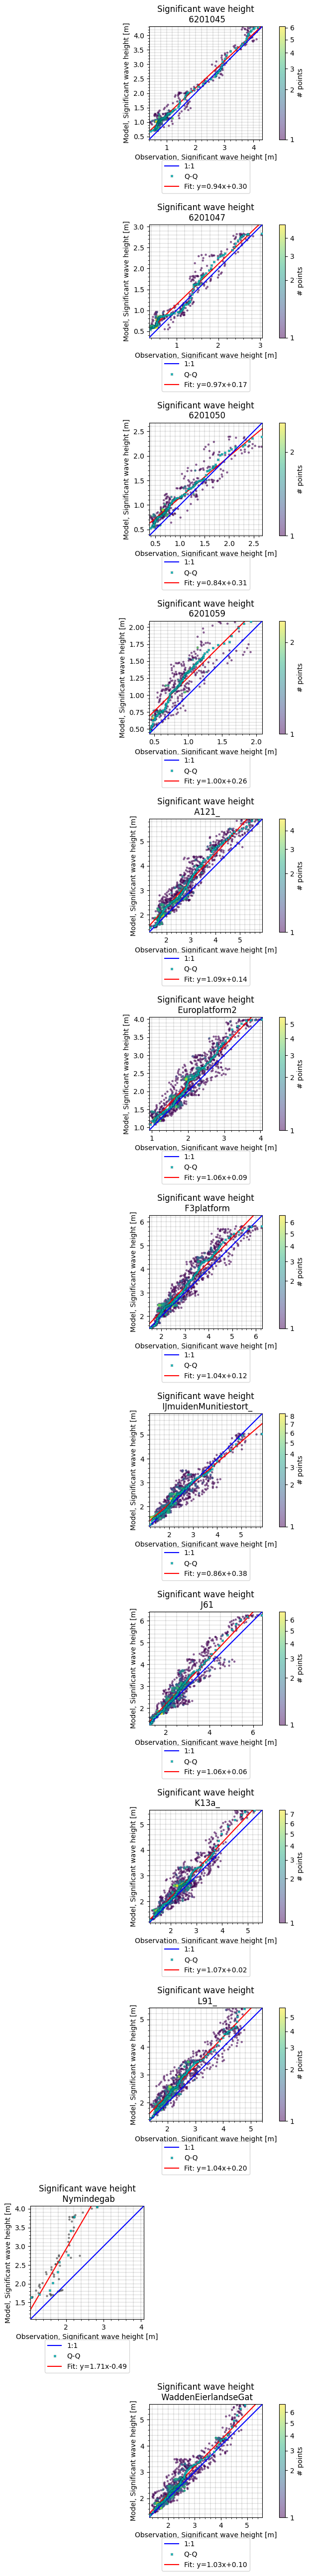

In [52]:
# Plot 
pl.plot_scatter_cc(cc = cc_swh, title='Significant wave height')

### Peak wave period

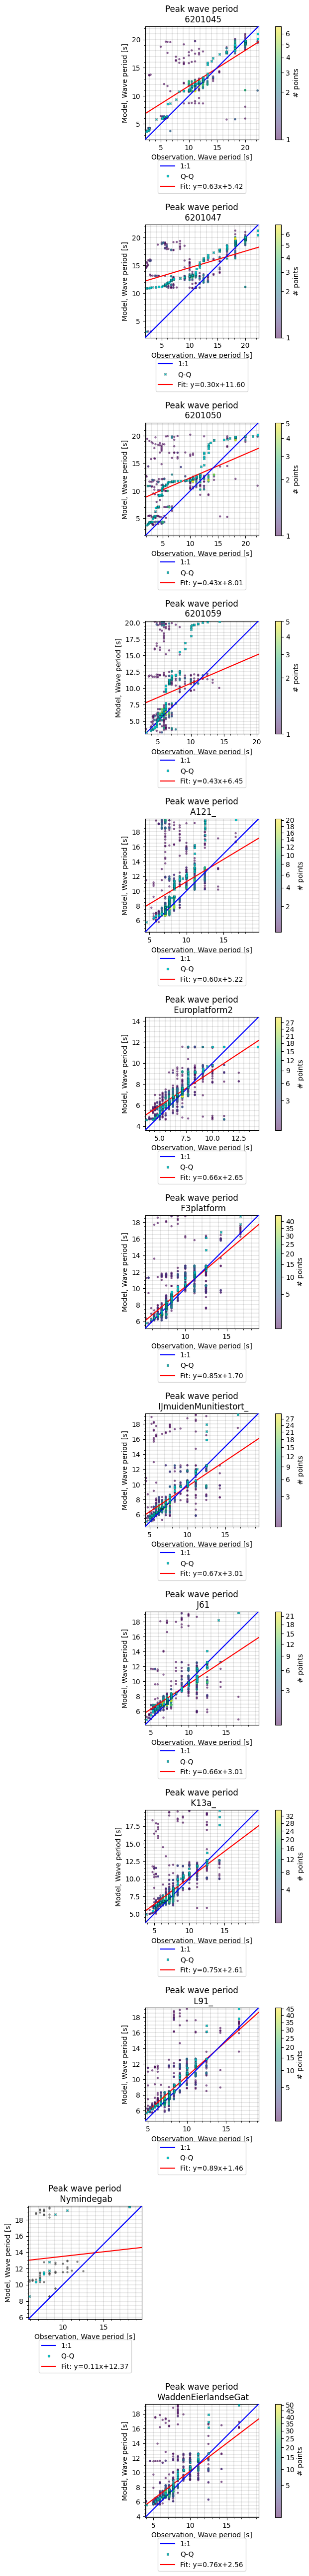

In [53]:
# Scatter plot
pl.plot_scatter_cc(cc = cc_tp, title='Peak wave period')

### Mean wave direction

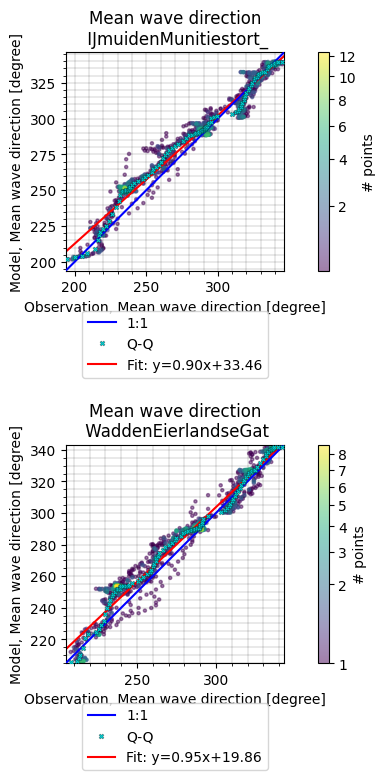

In [54]:
# Scatter plot
pl.plot_scatter_cc(cc = cc_dir, title='Mean wave direction')

## Timeseries

### Significant wave height

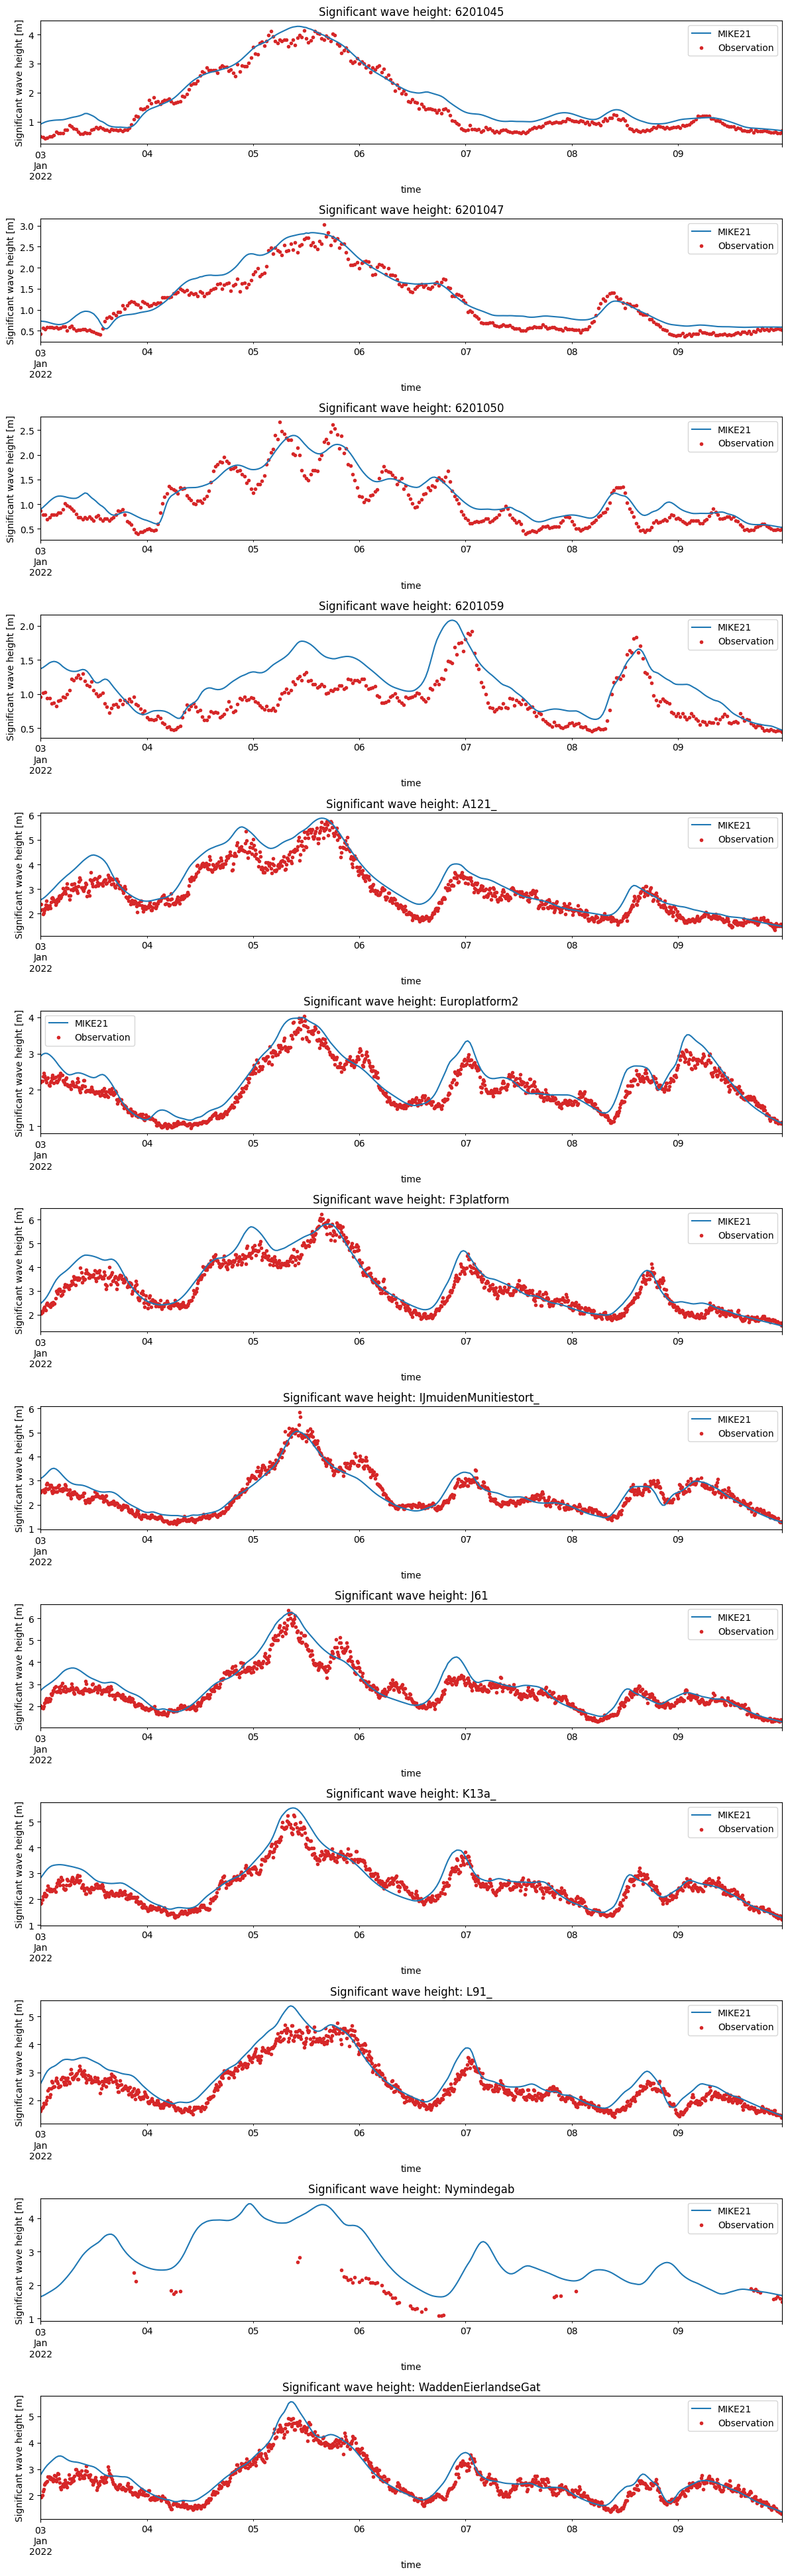

In [55]:
pl.plot_timeseries_currents(cc = cc_swh, title='Significant wave height')

### Peak wave period

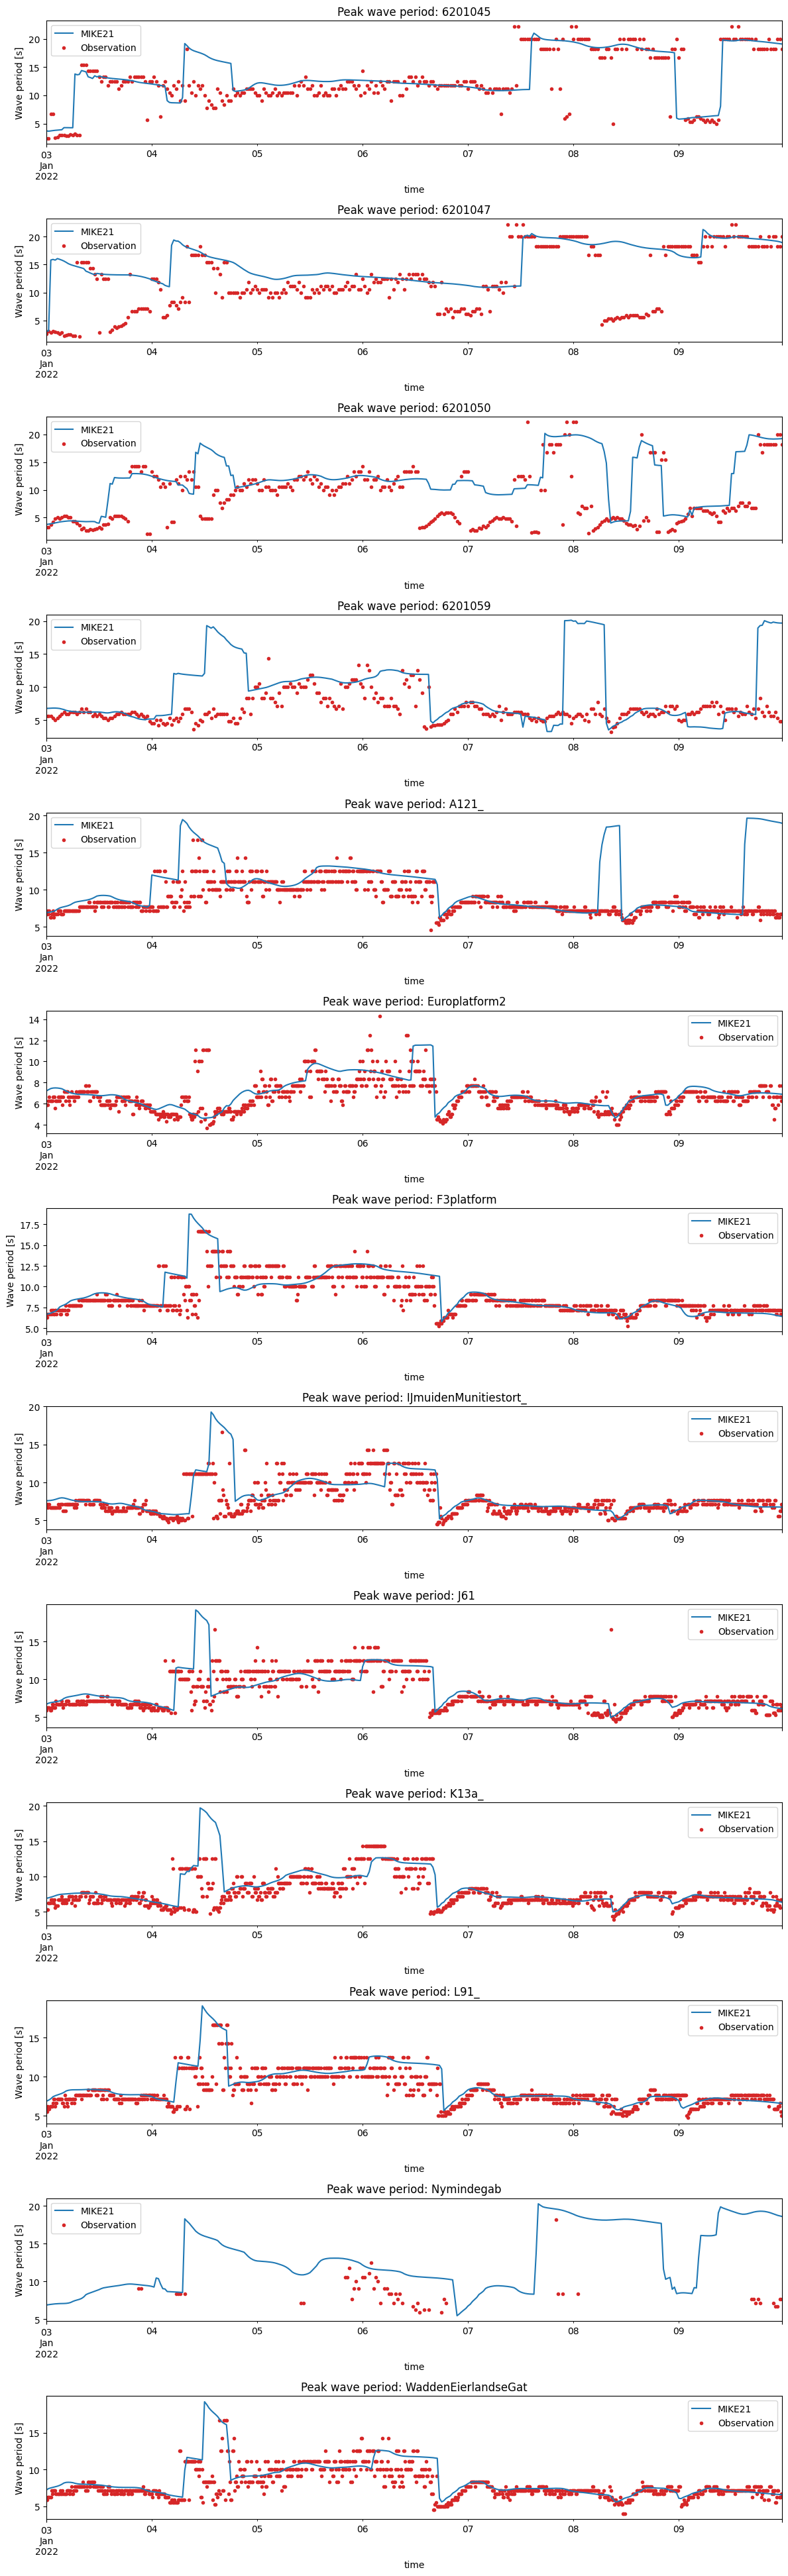

In [56]:
pl.plot_timeseries_currents(cc = cc_tp, title='Peak wave period')